In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from lime import lime_tabular

# Import the data
mydata = pd.read_csv("/Users/connorraney/QTMML/rawdata/Spam_Data.csv")

In [2]:
# Set model type: "C" for classification, "R" for regression
model_type = "C"

# Number of rounds for cross-validation
cv_nround = 500

# Response variable redefinition
mydata['myresponse'] = mydata['Status']  # Replace 'Status' with your response variable name
mydata = mydata.drop('Status', axis=1)  # Replace 'Status' with your response variable name

if model_type == "C":
    le = LabelEncoder()
    mydata['myresponse'] = le.fit_transform(mydata['myresponse'])

# Predictor transformation (if needed)
# mydata['xyz'] = mydata['xyz'].astype('category')

# Remove redundant variables (if needed)
# mydata = mydata.drop('xyz', axis=1)

In [3]:
# Split the data into features and target
X = mydata.drop('myresponse', axis=1)
y = mydata['myresponse']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y if model_type == "C" else None)

# One-hot encoding for categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [8]:
# Ensure X_test has the same columns as X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

from sklearn.model_selection import KFold

# Set up XGBoost parameters
params = {
    "max_depth": 1,
    "learning_rate": 0.3,
    "gamma": 0,
    "subsample": 1,
    "colsample_bytree": 1,
    "min_child_weight": 5,
    "n_jobs": 8
}

# Initialize lists to store results
cv_scores = []
n_estimators_range = range(1, cv_nround + 1, 10)  # Evaluate every 10th tree

if model_type == "C":
    if len(np.unique(y)) == 2:
        model = XGBClassifier(objective="binary:logistic", **params)
    else:
        model = XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y)), **params)
else:
    model = XGBRegressor(objective="reg:squarederror", **params)

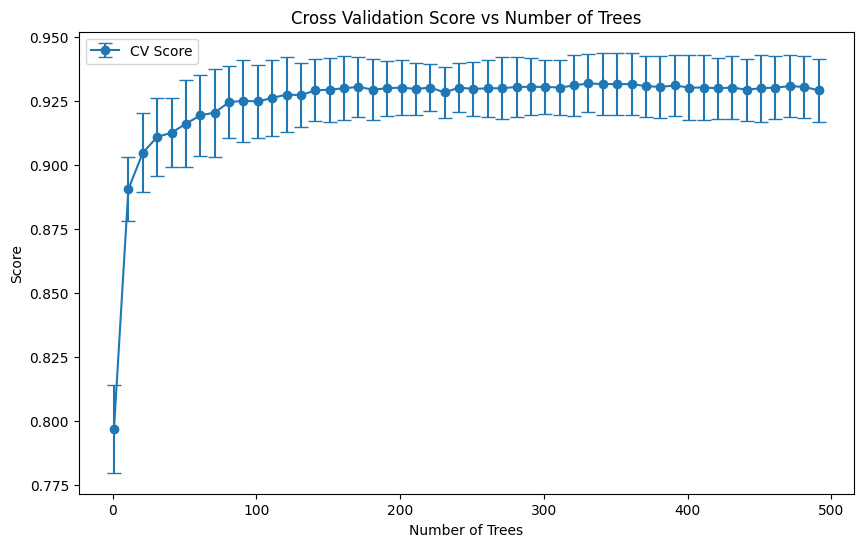

In [9]:
from sklearn.metrics import mean_squared_error
# Perform cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    if model_type == "C":
        model = XGBClassifier(objective="binary:logistic", **params)
    else:
        model = XGBRegressor(objective="reg:squarederror", **params)
    
    fold_scores = []
    for n_estimators in n_estimators_range:
        model.n_estimators = n_estimators
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        if model_type == "C":
            score = accuracy_score(y_val_fold, y_pred)
        else:
            score = -mean_squared_error(y_val_fold, y_pred)
        fold_scores.append(score)
    
    cv_scores.append(fold_scores)


# Calculate mean and std of CV scores
mean_scores = np.mean(cv_scores, axis=0)
std_scores = np.std(cv_scores, axis=0)

# Plot CV error vs number of trees
plt.figure(figsize=(10, 6))
plt.errorbar(n_estimators_range, mean_scores, yerr=std_scores, fmt='-o', capsize=5, label='CV Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score' if model_type == "C" else 'Negative MSE')
plt.title('Cross Validation Score vs Number of Trees')
plt.legend()
plt.show()

In [11]:
# Calculate mean scores across all folds
mean_scores = np.mean(cv_scores, axis=0)

# Find the optimal number of trees
optimal_trees = n_estimators_range[np.argmax(mean_scores)]
print(f"Optimal number of trees: {optimal_trees}")

# Train the model with the optimal number of trees
model.n_estimators = optimal_trees
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

Optimal number of trees: 331


In [12]:
# Evaluate the model
if model_type == "C":
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
else:
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

# LIME explanation
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=le.classes_ if model_type == "C" else None,
    mode="classification" if model_type == "C" else "regression"
)

Accuracy: 0.9273


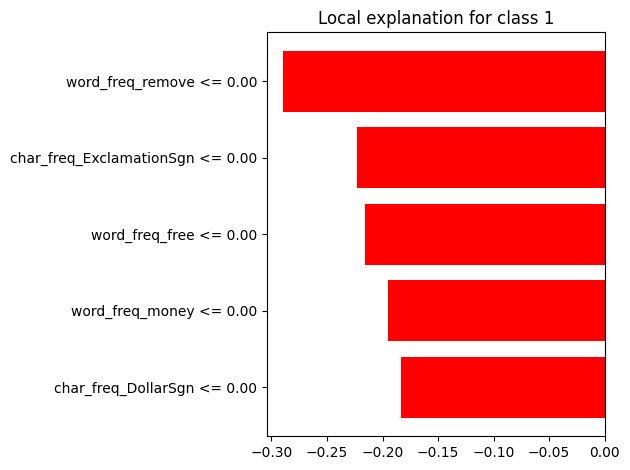

In [15]:
# Explain a specific instance
idx_to_explain = 1
exp = explainer.explain_instance(X_test.iloc[idx_to_explain].values, model.predict_proba if model_type == "C" else model.predict, num_features=5)

# Plot LIME explanation
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

# For making predictions on new data:
# new_data = pd.read_csv("new_data.csv")
# new_data = pd.get_dummies(new_data)
# new_data = new_data.reindex(columns=X_train.columns, fill_value=0)
# predictions = model.predict(new_data)

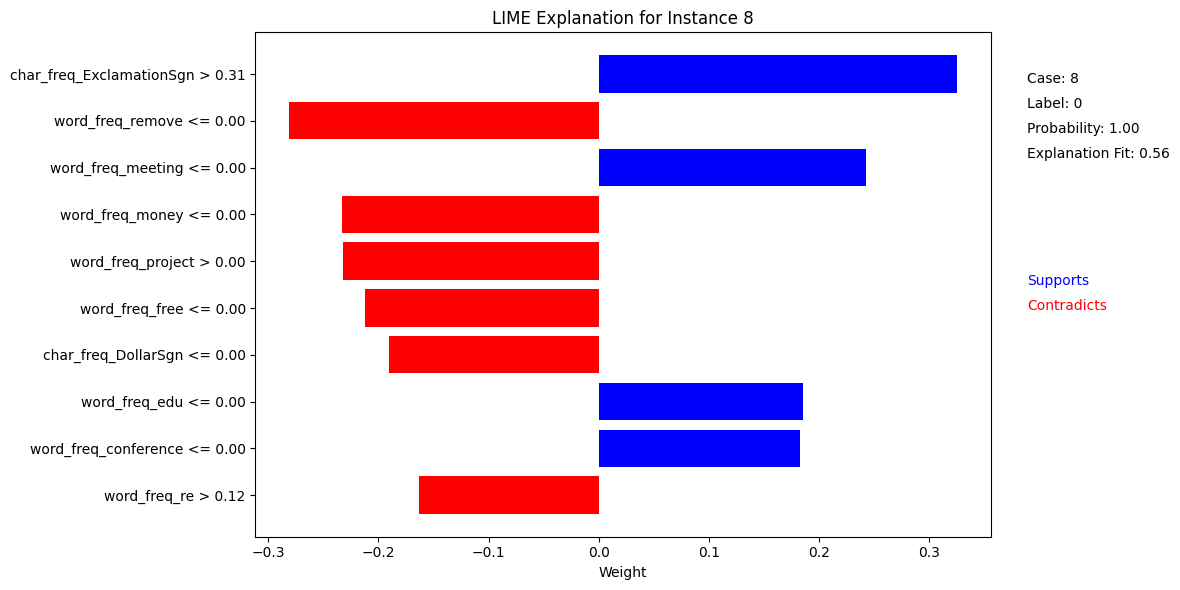

Prediction probabilities: Class 0: 1.00, Class 1: 0.00


In [24]:
# Lime Chart 1
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Assuming we've already split our data and trained our model

# Create the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=le.classes_ if model_type == "C" else None,
    mode="classification" if model_type == "C" else "regression"
)

# Choose a row to explain (equivalent to row.to.explain in R)
row_to_explain = 8

# Get the explanation
exp = explainer.explain_instance(
    X_test.iloc[row_to_explain].values, 
    model.predict_proba if model_type == "C" else model.predict,
    num_features=10,
    num_samples=500
)

# Create a plot similar to the R version
fig, ax = plt.subplots(figsize=(12, 6))

# Get feature importances
features = [x[0] for x in exp.as_list()]
weights = [x[1] for x in exp.as_list()]

# Create colors based on weight direction
colors = ['red' if w < 0 else 'blue' for w in weights]

# Create the bar plot
y_pos = np.arange(len(features))
ax.barh(y_pos, weights, align='center', color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Weight')
ax.set_title('LIME Explanation for Instance {}'.format(row_to_explain))

# Add a legend
ax.text(1.05, 0.5, 'Supports', color='blue', transform=ax.transAxes)
ax.text(1.05, 0.45, 'Contradicts', color='red', transform=ax.transAxes)

# Add prediction information
pred_proba = model.predict_proba(X_test.iloc[row_to_explain].values.reshape(1, -1))[0]
true_label = y_test.iloc[row_to_explain]
pred_label = np.argmax(pred_proba)

ax.text(1.05, 0.9, f'Case: {row_to_explain}', transform=ax.transAxes)
ax.text(1.05, 0.85, f'Label: {true_label}', transform=ax.transAxes)
ax.text(1.05, 0.8, f'Probability: {pred_proba[pred_label]:.2f}', transform=ax.transAxes)
ax.text(1.05, 0.75, f'Explanation Fit: {exp.score:.2f}', transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Print prediction probabilities
print(f"Prediction probabilities: Class 0: {pred_proba[0]:.2f}, Class 1: {pred_proba[1]:.2f}")

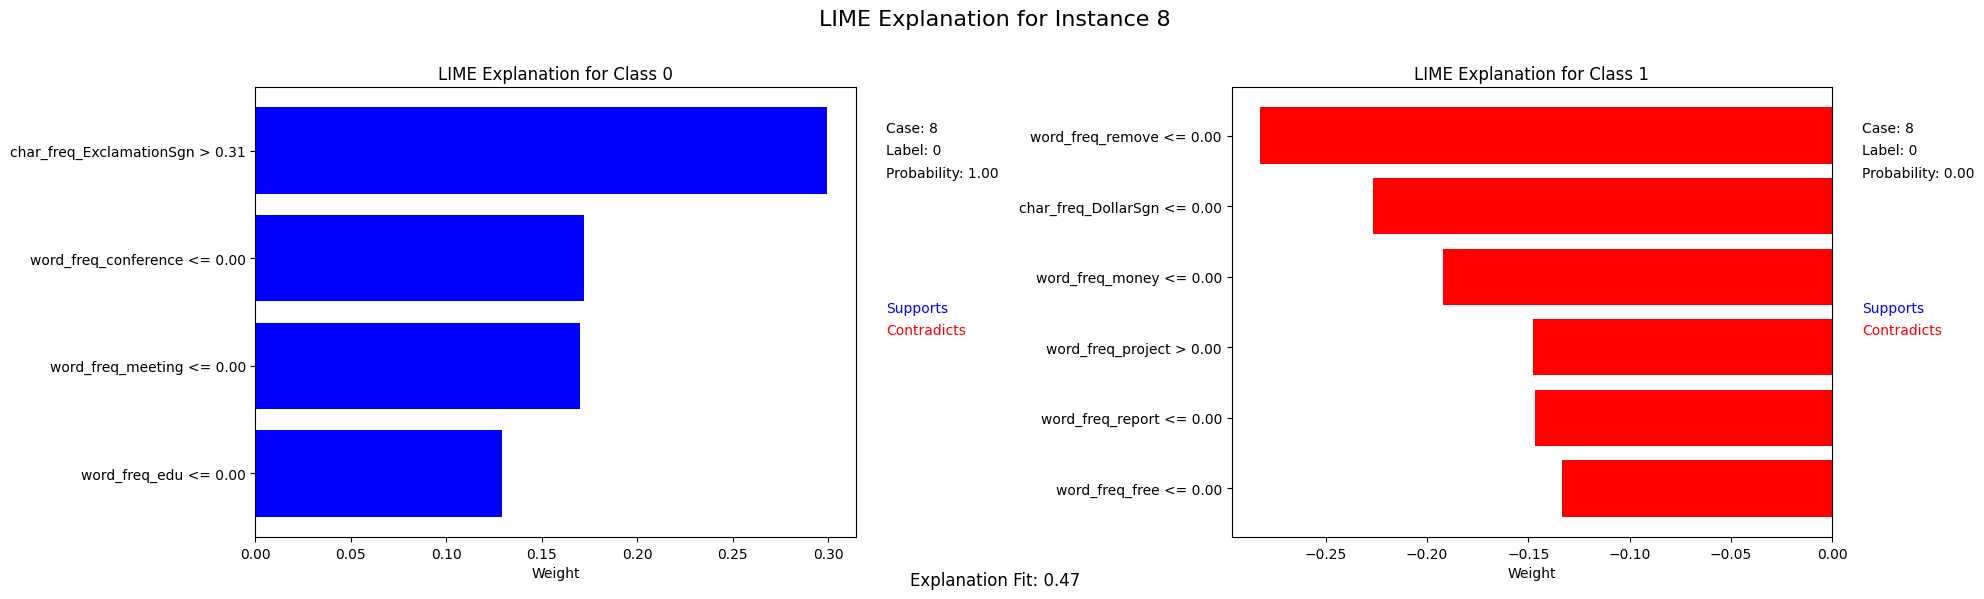

Prediction probabilities: 0: 1.00, 1: 0.00


In [29]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Assuming we've already split our data and trained our model

# Create the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=le.classes_,
    mode="classification"
)

# Choose a row to explain
row_to_explain = 8

# Get the explanation
exp = explainer.explain_instance(
    X_test.iloc[row_to_explain].values, 
    model.predict_proba,
    num_features=10,
    num_samples=500
)

# Create a plot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Function to plot LIME explanation for a single class
def plot_lime_explanation(ax, exp_list, class_name, probability, case, label):
    features, weights = zip(*exp_list)
    colors = ['red' if w < 0 else 'blue' for w in weights]
    y_pos = np.arange(len(features))
    ax.barh(y_pos, weights, align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Weight')
    ax.set_title(f'LIME Explanation for Class {class_name}')
    ax.text(1.05, 0.5, 'Supports', color='blue', transform=ax.transAxes)
    ax.text(1.05, 0.45, 'Contradicts', color='red', transform=ax.transAxes)
    
    # Add case, probability, and label information
    ax.text(1.05, 0.9, f'Case: {case}', transform=ax.transAxes)
    ax.text(1.05, 0.85, f'Label: {label}', transform=ax.transAxes)
    ax.text(1.05, 0.8, f'Probability: {probability:.2f}', transform=ax.transAxes)

# Get prediction probabilities
pred_proba = model.predict_proba(X_test.iloc[row_to_explain].values.reshape(1, -1))[0]

# Determine the class labels based on probabilities
class_labels = sorted(zip(le.classes_, pred_proba), key=lambda x: x[1], reverse=True)

# Get explanations for both classes
exp_list = exp.as_list()
exp_list_class1 = [x for x in exp_list if x[1] > 0]
exp_list_class2 = [x for x in exp_list if x[1] < 0]

# Get true label
true_label = y_test.iloc[row_to_explain]

# Plot explanations for both classes
plot_lime_explanation(ax1, exp_list_class1, class_labels[0][0], class_labels[0][1], row_to_explain, true_label)
plot_lime_explanation(ax2, exp_list_class2, class_labels[1][0], class_labels[1][1], row_to_explain, true_label)

fig.suptitle(f'LIME Explanation for Instance {row_to_explain}', fontsize=16)
fig.text(0.5, 0.02, f'Explanation Fit: {exp.score:.2f}', ha='center', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.1)
plt.show()

# Print prediction probabilities
print(f"Prediction probabilities: {class_labels[0][0]}: {class_labels[0][1]:.2f}, {class_labels[1][0]}: {class_labels[1][1]:.2f}")

In [18]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate classification report
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

Model Accuracy: 0.9273

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       558
           1       0.91      0.90      0.91       363

    accuracy                           0.93       921
   macro avg       0.92      0.92      0.92       921
weighted avg       0.93      0.93      0.93       921



Model Accuracy: 0.9273

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       558
           1       0.91      0.90      0.91       363

    accuracy                           0.93       921
   macro avg       0.92      0.92      0.92       921
weighted avg       0.93      0.93      0.93       921



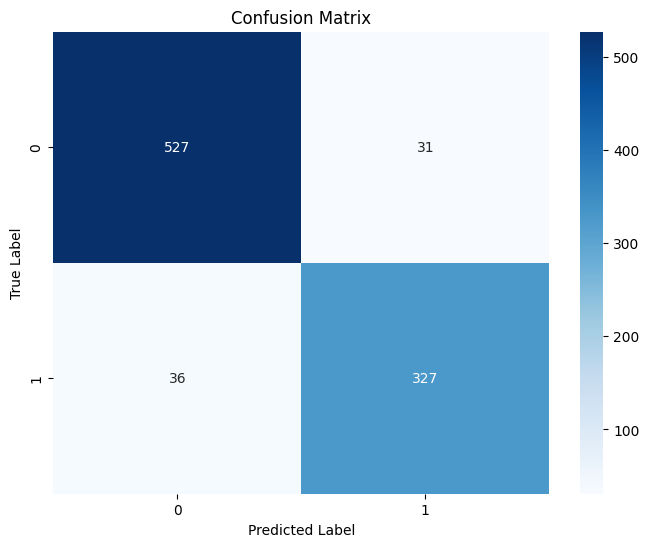

Specificity: 0.9444
Sensitivity: 0.9008


In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate classification report
report = classification_report(y_test, y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate specificity and sensitivity
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Specificity: {specificity:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")